In [ ]:
#dataset - https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbC01NWdXQUtCaW8xQ21CdW1pemd5R0QycHp3QXxBQ3Jtc0treWhVX21vRkVFd09LaG1zQ0JuLUpfOWlZWGpBbWg1RGsxX21RUTRTZWFVY2JXZ2dkT3c1VlNpdjU4ZUZTb3pWalFfM091LVo2VlhsVkxWaGRRdnN4dnBLbzBLcnFBTmlKYzgydVc1ZEo0VXBZeDdHSQ&q=https%3A%2F%2Fgithub.com%2FBekBrace%2FSales-Forecast-data-csv&v=20fbgWm5M2o


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
store_sales=pd.read_csv('/content/train_linear_regression.csv')
store_sales.head(10)

,date,store,item,sales
0,01-01-2013,1,1,13
1,02-01-2013,1,1,11
2,03-01-2013,1,1,14
3,04-01-2013,1,1,13
4,05-01-2013,1,1,10
5,06-01-2013,1,1,12
6,07-01-2013,1,1,10
7,08-01-2013,1,1,9
8,09-01-2013,1,1,12
9,10-01-2013,1,1,9


In [ ]:
#check for null values
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268166 entries, 0 to 268165
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    268166 non-null  object
 1   store   268166 non-null  int64 
 2   item    268166 non-null  int64 
 3   sales   268166 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 8.2+ MB


In [ ]:
#dropping store and item columns
store_sales=store_sales.drop(['store','item'],axis=1)
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268166 entries, 0 to 268165
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    268166 non-null  object
 1   sales   268166 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.1+ MB


Convert date column from object data-type to dateTime data-type

In [ ]:
store_sales['date']=pd.to_datetime(store_sales['date'])
store_sales.info()

<ipython-input-6-19c0639cede6>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  store_sales['date']=pd.to_datetime(store_sales['date'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268166 entries, 0 to 268165
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    268166 non-null  datetime64[ns]
 1   sales   268166 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.1 MB



converting date to a month-period and sum the number of items in each month

In [ ]:
store_sales['date']=store_sales['date'].dt.to_period("M")
monthly_sales=store_sales.groupby("date").sum().reset_index()


convert the resulting date to timestamp data type

In [ ]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [ ]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,167696
1,2013-02-01,163719
2,2013-03-01,201202
3,2013-04-01,208519
4,2013-05-01,224865
5,2013-06-01,233264
6,2013-07-01,248046
7,2013-08-01,227172
8,2013-09-01,210886
9,2013-10-01,207900


Visualization

Text(0.5, 1.0, 'Monthly sales')

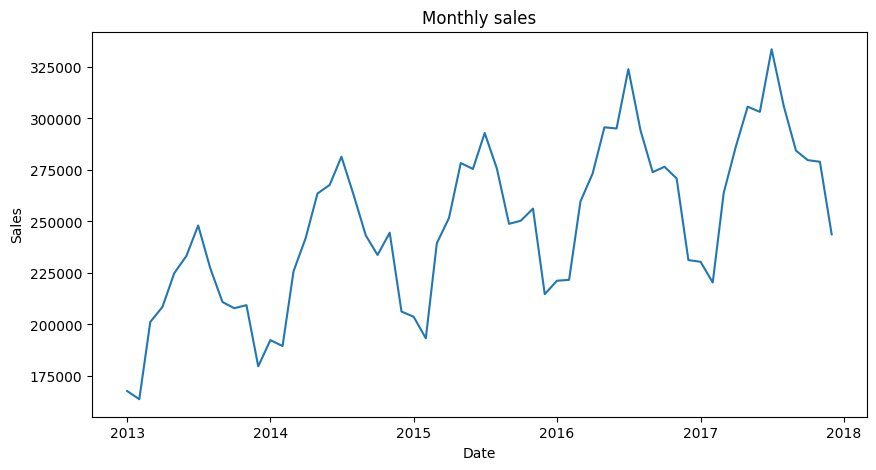

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly sales")

Call the difference on the sales to make the sale data stationary

In [ ]:
monthly_sales['sales_diff']=monthly_sales['sales'].diff()
monthly_sales=monthly_sales.dropna()
monthly_sales.head()

,date,sales,sales_diff
1,2013-02-01,163719,-3977.0
2,2013-03-01,201202,37483.0
3,2013-04-01,208519,7317.0
4,2013-05-01,224865,16346.0
5,2013-06-01,233264,8399.0


Text(0.5, 1.0, 'Monthly customer sales difference')

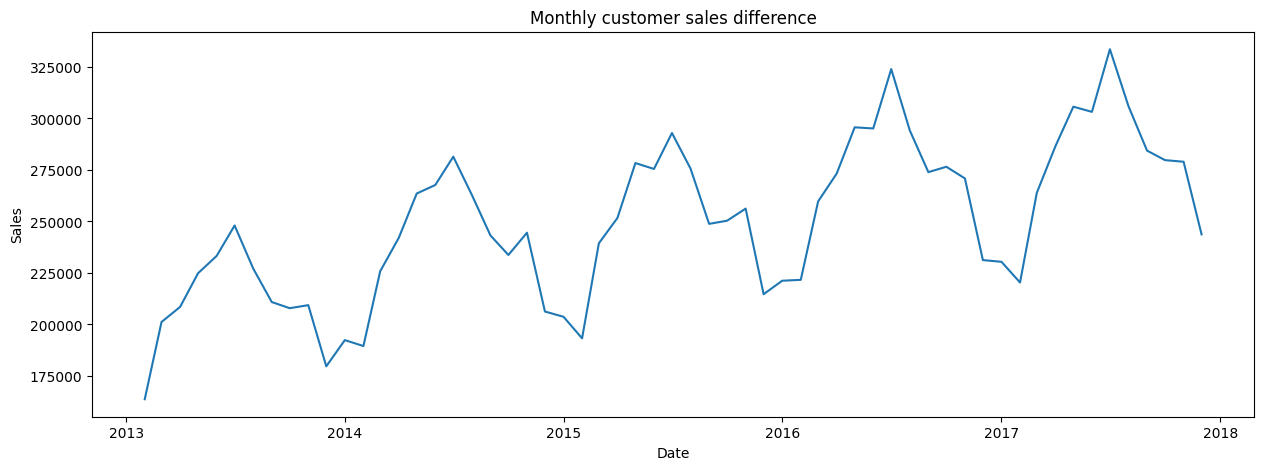

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly customer sales difference")


Dropping off sales and date

In [ ]:
supervised_data=monthly_sales.drop(['date','sales'], axis=1)

preparing supervised data

In [ ]:
for i in range(1,13):
  col_name='month_'+str(i)
  supervised_data[col_name]=supervised_data['sales_diff'].shift(i)
supervised_data=supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-2882.0,12731.0,-29691.0,1473.0,-2986.0,-16286.0,-20874.0,14782.0,8399.0,16346.0,7317.0,37483.0,-3977.0
1,36293.0,-2882.0,12731.0,-29691.0,1473.0,-2986.0,-16286.0,-20874.0,14782.0,8399.0,16346.0,7317.0,37483.0
2,16202.0,36293.0,-2882.0,12731.0,-29691.0,1473.0,-2986.0,-16286.0,-20874.0,14782.0,8399.0,16346.0,7317.0
3,21525.0,16202.0,36293.0,-2882.0,12731.0,-29691.0,1473.0,-2986.0,-16286.0,-20874.0,14782.0,8399.0,16346.0
4,4153.0,21525.0,16202.0,36293.0,-2882.0,12731.0,-29691.0,1473.0,-2986.0,-16286.0,-20874.0,14782.0,8399.0
5,13727.0,4153.0,21525.0,16202.0,36293.0,-2882.0,12731.0,-29691.0,1473.0,-2986.0,-16286.0,-20874.0,14782.0
6,-18549.0,13727.0,4153.0,21525.0,16202.0,36293.0,-2882.0,12731.0,-29691.0,1473.0,-2986.0,-16286.0,-20874.0
7,-19654.0,-18549.0,13727.0,4153.0,21525.0,16202.0,36293.0,-2882.0,12731.0,-29691.0,1473.0,-2986.0,-16286.0
8,-9501.0,-19654.0,-18549.0,13727.0,4153.0,21525.0,16202.0,36293.0,-2882.0,12731.0,-29691.0,1473.0,-2986.0
9,10805.0,-9501.0,-19654.0,-18549.0,13727.0,4153.0,21525.0,16202.0,36293.0,-2882.0,12731.0,-29691.0,1473.0


Splitting into train and test

In [ ]:
train_Data=supervised_data[:-12]
test_Data=supervised_data[-12:]
print(train_Data.shape, test_Data.shape)

(35, 13) (12, 13)


In [ ]:
scaler=MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_Data)
train_Data=scaler.transform(train_Data)
test_Data=scaler.transform(test_Data)

In [ ]:
x_train, y_train =train_Data[:,1:],train_Data[:,0:1]
x_test, y_test =test_Data[:,1:],test_Data[:,0:1]
y_train=y_train.ravel()
y_test=y_test.ravel()
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(35, 12) (35,) (12, 12) (12,)


MAke prediction df to merge the predicted sale prices of all trained algos

In [ ]:
sales_dates=monthly_sales['date'][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)

In [ ]:
#actual sales
act_sales=monthly_sales['sales'][-13:].to_list()
print(act_sales)

[231245, 230415, 220367, 263893, 286471, 305701, 303186, 333589, 305948, 284380, 279762, 278979, 243730]


To create linear regression model and predicted output

In [ ]:
lr_model=LinearRegression()
lr_model.fit(x_train,y_train)
lr_pred=lr_model.predict(x_test)

In [ ]:
lr_pred=lr_pred.reshape(-1,1)
lr_pred_test_set=np.concatenate([lr_pred,x_test],axis=1)
lr_pred_test_Set=scaler.inverse_transform(lr_pred_test_set)

In [ ]:
result_list=[]
for index in range(0,len(lr_pred_test_set)):
  result_list.append(lr_pred_test_set[index][0]+act_sales[index])
lr_pred_series=pd.Series(result_list,name='Linear Prediction')
predict_df=predict_df.merge(lr_pred_series,left_index=True,right_index=True)


In [ ]:
print(predict_df)

         date  Linear Prediction
0  2017-01-01      231245.121691
1  2017-02-01      230415.042203
2  2017-03-01      220367.930730
3  2017-04-01      263893.377739
4  2017-05-01      286471.430113
5  2017-06-01      305701.048644
6  2017-07-01      303186.773367
7  2017-08-01      333588.270526
8  2017-09-01      305947.629108
9  2017-10-01      284380.077158
10 2017-11-01      279761.813069
11 2017-12-01      278978.057569


In [ ]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:]))
print(lr_mse)
lr_mae=mean_absolute_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
print(lr_mae)
lr_r2=r2_score(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
print(lr_r2)

22912.409889722974
18248.712335022432
0.5280402654153868


visualization of actual vs predicted

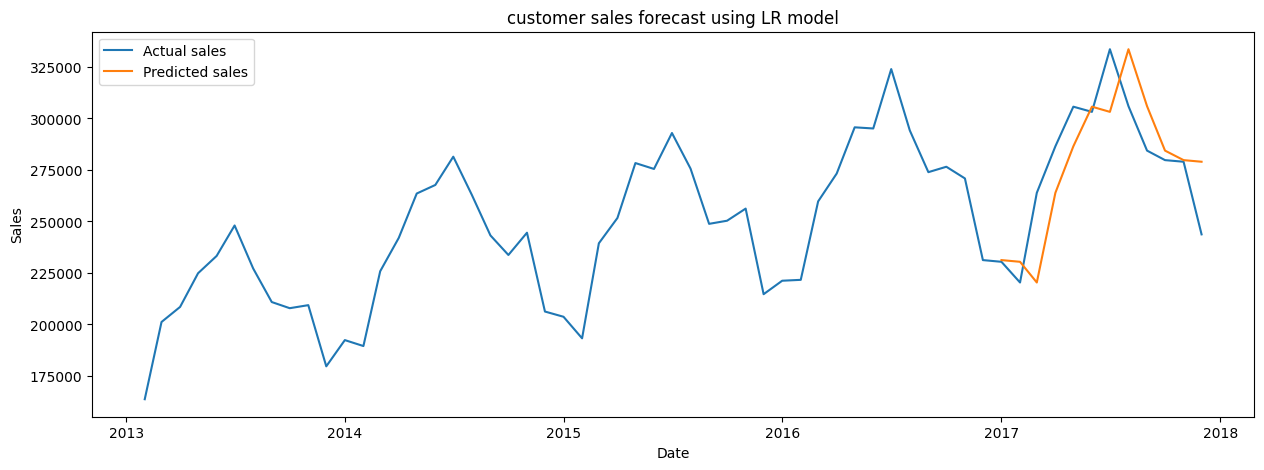

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales']) #actual sales
plt.plot(predict_df['date'],predict_df['Linear Prediction']) #predicted sales
plt.title("customer sales forecast using LR model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual sales', 'Predicted sales'])
plt.show()
